# Studying the Growth Factor

Reference: [Cosmological Perturbation Theory in the Synchronous and Conformal
 Newtonian Gauges](https://arxiv.org/pdf/astro-ph/9506072), by Chung-Pei Ma and Edmund Bertschinger.

The equations governing the matter perturbations (in the Newtonian gauge) in a CDM-dominated universe are:

\begin{align}
    \delta_m' &= -\theta_m + 3\Phi' \\
    \theta_m' &= -\mathcal{H}\theta_m + k^2\Psi \\
    \Phi' &= 4\pi Ga^2(\rho + P)\frac{\theta}{k^2} - \mathcal{H}\Psi\\
    k^2 (\Phi - \Psi) &= 0 \\
\end{align}

I will use Mpc units. Assuming $c = 1$, we have $\mathrm{km}/\mathrm{s} = 1/299.792,458$; therefore, $H_0 = 100h/299.792,458 \, \mathrm{Mpc}^{-1}$.

Furthermore, $8\pi G \rho_\mathrm{cr} = 3H_0^2$, which is in $\mathrm{Mpc}^{-2}$. For all equations, we only need to input $8\pi G \rho_\mathrm{cr}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, quad
from scipy.optimize import root_scalar

In [75]:
# TODO: convert units to Mpc
# Constants
c_in_km_s = 299_792.458

# Free and derived parameters
h = 0.7
H0 = 100*h/c_in_km_s # 1/Mpc
rho_crit = 3*H0**2 # 1/Mpc^2
Omega_m = 0.3
Omega_r = 2.5e-5
Omega_Lambda = 1 - Omega_m - Omega_r
a_eq = Omega_r/Omega_m
w_gamma = 1/3
w_m = 0
w_Lambda = -1

# Densities (8*\pi*G*\rho)
def rho_m(a):
    return rho_crit*Omega_m*a**-3

def rho_gamma(a):
    return rho_crit*Omega_r*a**-4

def rho_lambda(a):
    return rho_crit*Omega_Lambda

def rho_tot(a):
    return rho_crit*(Omega_r*a**-4 + Omega_m*a**-3 + Omega_Lambda)

def P(a):
    return rho_crit*(w_gamma*Omega_r*a**-4 + w_m*Omega_m*a**-3 + w_Lambda*Omega_Lambda)

def H_curly(a):
    return a*np.sqrt(rho_tot(a)/3)

def scale_factor_horizon_entry(k):
    # Find the value of `a` such that k = H_curly
    return np.exp(root_scalar(lambda loga: H_curly(np.exp(loga)) - k, x0=-15).root)

# Derivative of the system with respect to scale factor
def dy_da(y, a, k=0.1):
    delta_m, theta_m, delta_gamma, theta_gamma, Phi = y
    H = H_curly(a)
    rho_m_now = rho_m(a)
    rho_gamma_now = rho_gamma(a)
    sigma_gamma = 0 # TODO: implement anisotropic stress, for now it's zero
    Phi_prime   = -H*Phi + 0.5*a**2*rho_m_now*theta_m/k**2 + 0.5*a**2*(1 + w_gamma)*rho_gamma_now*theta_gamma/k**2
    delta_m_prime = -theta_m + 3*Phi_prime
    theta_m_prime = -H*theta_m + k**2 * Phi
    delta_gamma_prime = -4*theta_gamma/3 + 4*Phi_prime
    theta_gamma_prime = k**2*(delta_gamma/4 - sigma_gamma) + k**2 * Phi
    return [delta_m_prime/(a*H), theta_m_prime/(a*H), delta_gamma_prime/(a*H), theta_gamma_prime/(a*H), Phi_prime/(a*H)]

def dy_dloga(y, loga, k=0.1):
    a = np.exp(loga)
    deriv = dy_da(y, a, k)
    return list(map(lambda x: a*x, deriv))

def integrate(k):
    # Initial conditions
    tau_ini = 3e-4
    a_ini = H0*np.sqrt(Omega_r)*tau_ini + H0**2*Omega_m*tau_ini**2/4
    C = 1 # Arbitrary scale of adiabatic initial conditions
    Phi_ini = 4/3*C # Primordial curvature perturbation
    delta_gamma_ini = -2*Phi_ini
    theta_gamma_ini = 0.5*k**2*tau_ini*Phi_ini
    delta_c_ini = 3*delta_gamma_ini/4
    theta_c_ini = theta_gamma_ini
    y0 = [delta_c_ini, theta_c_ini, delta_gamma_ini, theta_gamma_ini, Phi_ini]

    # Defining scale factor grid for integration
    a_switch = 1e-1
    loga_int = np.linspace(np.log(a_ini), np.log(a_switch), 1000)
    a_int_lin = np.linspace(a_switch, 1, 700)
    a = np.concatenate([np.exp(loga_int), a_int_lin])

    partial = odeint(dy_dloga, y0, t=loga_int, args=(k,))
    y_switch = partial[-1]
    partial2 = odeint(dy_da, y_switch, t=a_int_lin, args=(k,))
    return a, np.concatenate([partial, partial2])

ks = [1e-3, 1e-2, 1e-1, 1]
results = []
for k in ks:
    a, result = integrate(k)
    results.append(result)

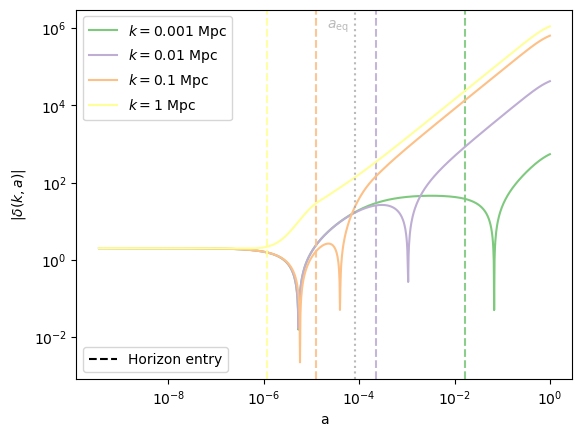

In [76]:
# From https://colorbrewer2.org/#type=qualitative&scheme=Accent&n=6
colors = [
    "#7fc97f",
    "#beaed4",
    "#fdc086",
    "#ffff99",
    "#386cb0",
    "#f0027f"
]

fig, ax = plt.subplots()
for k, result, color in zip(ks, results, colors):
    delta_m, theta_m, delta_gamma, theta_gamma, Phi = result.T
    ax.loglog(a, np.abs(delta_m), label=f"$k = {k}$ Mpc", color=color)
    a_horizon_entry = scale_factor_horizon_entry(k)
    ax.axvline(a_horizon_entry, alpha=0.9, ls="--", color=color)


ax.axvline(a_eq, c="darkgray", alpha=0.8, ls=":")
ax.text(a_eq/4, 1e6, r"$a_\mathrm{eq}$", c="darkgray", alpha=0.8)

ax.set_xlabel("a")
ax.set_ylabel(r"$|\delta(k, a)|$")
ax.legend()

import matplotlib
line = matplotlib.lines.Line2D([], [], color='black', ls="--", label='Horizon entry')
legend = ax.legend()
ax.add_artist(legend)
ax.legend(handles=[line], loc="lower left")
plt.savefig("deltas.pdf")